# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Second validation example: FCC structure

<div class="row">
  <div class="col-md-7" markdown="1">
  This validation increases the complexity of the first example by adding contact between spherical bodies while the volume fraction and surface area can still be expressed analytically as a function of the unit cell side length. This validation is well suited as
<ul>
  <li>the surface is analytically known,</li>
  <li>the example is 3D but yet simple,</li>
  <li>the surface is curved and, thus, will suffer from pixelation issues</li>
  <li>the example can be used to compute tortuosity in the solid and the pore space.</li>
</ul>
<br>
Without a defined overlap, a voxelization issue arises where for all configurations with an even number of voxels per cube length the spheres are touching at voxel edges while for all odd configurations the spheres are fully connected. This can be seen in the front view of the cube:
  </div>
  <div class="col-md-5" markdown="1">
  <img src="data-paper/fcc-study/fcc_solid_3D.png" alt="Image 1" width="220" />
  </div>
</div>
<br>

<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_10_pure.png" alt="2pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_11_pure.png" alt="5pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_50_pure.png" alt="10pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_51_pure.png" alt="20pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_100_pure.png" alt="50pixel" width="100" />
</p>
<p style="display: inline-block; margin-right: 10px;">
  <img src="data-paper/fcc-study/fcc_101_pure.png" alt="100pixel" width="100" />
</p>


**Author**: Simon Daubner<br>
**Department**: Department of Mechanical Engineering<br>
**Institution**: Karlsruhe Institute of Technology

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau
import torch

import metrics
import data
import time

We initialize the grid resolution as

In [11]:
dx = 1.0

In [12]:
fcc_results = {}
overlaps = [0.0,0.05] #[0.01,0.05,0.1,0.2]

for overlap in overlaps:
    resolution = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,50,51,100,101,200,201,300,301]

    # Initialize fields
    fcc_vol_fraction = {'theo':np.zeros(len(resolution)),
                        'num':np.zeros(len(resolution))}

    methods = ['theo', 'faces', 'marching', 'conv_marching', 'porespy', 'gradient', 'conv_gradient', 'gradient_GPU']
    area = {method: np.zeros(len(resolution)) for method in methods}
    times = {method: np.zeros(len(resolution)) for method in methods[1:]}
    time_CPU_GPU = np.zeros(len(resolution))

    connectivity_type = ['s_side', 's_edge', 's_corner', 'p_side', 'p_edge', 'p_corner']
    connectivity = {conn: np.zeros(len(resolution)) for conn in connectivity_type}
    tortuosity   = {'solid': np.zeros(len(resolution)),
                    'pore': np.zeros(len(resolution))}

    for i, pixels in enumerate(resolution):
        sharp_field = data.create_fcc_cube(pixels, overlap=overlap)
        vol, surf = data.theoretical_fcc_metrics(pixels, overlap)
        fcc_vol_fraction['theo'][i] = vol
        fcc_vol_fraction['num'][i] = metrics.volume_fraction(sharp_field, 1)

        timer=[]
        area['theo'][i] = surf
        timer.append(time.time())
        area['faces'][i] = 3*tau.surface_area(sharp_field, phases=[1]).item()
        timer.append(time.time())
        area['marching'][i] = metrics.specific_surface_area_marching(sharp_field)
        timer.append(time.time())
        phase_field = metrics.smooth_with_convolution(sharp_field)
        area['conv_marching'][i] = metrics.specific_surface_area_marching(phase_field)
        timer.append(time.time())
        area['porespy'][i]  = metrics.specific_surface_area_porespy(sharp_field)
        timer.append(time.time())
        area['gradient'][i] = metrics.specific_surface_area(sharp_field)
        timer.append(time.time())
        area['conv_gradient'][i] = metrics.specific_surface_area(sharp_field, smooth=1)
        timer.append(time.time())

        # Test GPU speed-up using pytorch
        # Separate time measurements for shifting from CPU to GPU and actual computation
        tensor = torch.tensor(sharp_field, dtype=torch.float32)
        tensor = tensor.to('cuda')
        timer.append(time.time())

        grad = torch.gradient(tensor, spacing=(dx,dx,dx))
        norm2 = grad[0].pow(2) + grad[1].pow(2) + grad[2].pow(2)
        surface_area = torch.sum(torch.sqrt(norm2))
        surface_area = surface_area.cpu().item()
        volume = np.prod(sharp_field.shape)
        area['gradient_GPU'][i] = surface_area / volume
        timer.append(time.time())

        for k, method in enumerate(methods[1:]):
            times[method][i] = np.array(timer)[k+1]-np.array(timer)[k]

        time_CPU_GPU[i] = timer[7]-timer[6]
        times['gradient_GPU'][i] = timer[8]-timer[7]

        # Compute through feature and tortuosity
        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 1, 'x')
        connectivity['s_side'][i] = through_fraction[0]
        connectivity['s_edge'][i] = through_fraction[1]
        connectivity['s_corner'][i] = through_fraction[2]

        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0], run_on='cuda')
            if res<1000: tortuosity['solid'][i] = res

        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 0, 'x')
        connectivity['p_side'][i] = through_fraction[0]
        connectivity['p_edge'][i] = through_fraction[1]
        connectivity['p_corner'][i] = through_fraction[2]

        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0], run_on='cuda')
            if res<1000: tortuosity['pore'][i] = res
        print(f"Finished FCC with {pixels}^3 voxels.")

    fcc_results[f'overlap{int(100*overlap)}'] = {'vol':fcc_vol_fraction,
                                                 'area':area,
                                                 'time':times,
                                                 'connected':connectivity,
                                                 'taufactor':tortuosity}

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.3333334922790527                   after: 1 iterations in: 0.0119                    seconds at a rate of 0.0119 s/iter
Finished FCC with 6^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.445708990097046                   after: 101 iterations in: 0.0232                    seconds at a rate of 0.0002 s/iter
Finished FCC with 7^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Finished FCC with 8^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0011                    seconds at a rate of 0.0011 s/iter
converged to: inf                   after: 1 iterations in: 0.001                    seconds at a rate of 0.0011 s/iter
Finished FCC with 9^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.6000001430511475                   after: 1 iterations in: 0.0048                    seconds at a rate of 0.0048 s/iter
Finished FCC with 10^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.001                    seconds at a rate of 0.001 s/iter
converged to: inf                   after: 1 iterations in: 0.0011                    seconds at a rate of 0.0011 s/iter
Finished FCC with 11^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.555558204650879                   after: 101 iterations in: 0.0232                    seconds at a rate of 0.0002 s/iter
Finished FCC with 12^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.3880300521850586                   after: 101 iterations in: 0.0225                    seconds at a rate of 0.0002 s/iter
converged to: 4.091120719909668                   after: 101 iterations in: 0.0224                    seconds at a rate of 0.0002 s/iter
Finished FCC with 13^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.7367353439331055                   after: 101 iterations in: 0.0227                    seconds at a rate of 0.0002 s/iter
Finished FCC with 14^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.7080395221710205                   after: 101 iterations in: 0.0227                    seconds at a rate of 0.0002 s/iter
converged to: 3.4616785049438477                   after: 101 iterations in: 0.0223                    seconds at a rate of 0.0002 s/iter
Finished FCC with 15^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.6577842235565186                   after: 101 iterations in: 0.0222                    seconds at a rate of 0.0002 s/iter
Finished FCC with 16^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.001                    seconds at a rate of 0.001 s/iter
converged to: inf                   after: 1 iterations in: 0.0009                    seconds at a rate of 0.0009 s/iter
Finished FCC with 17^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.5371131896972656                   after: 101 iterations in: 0.0228                    seconds at a rate of 0.0002 s/iter
Finished FCC with 18^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.9671061038970947                   after: 101 iterations in: 0.0243                    seconds at a rate of 0.0002 s/iter
converged to: 2.799781322479248                   after: 101 iterations in: 0.0233                    seconds at a rate of 0.0002 s/iter
Finished FCC with 19^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.139294385910034                   after: 101 iterations in: 0.0257                    seconds at a rate of 0.0003 s/iter
Finished FCC with 20^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.8968725204467773                   after: 101 iterations in: 0.0354                    seconds at a rate of 0.0004 s/iter
converged to: 2.836069345474243                   after: 101 iterations in: 0.0231                    seconds at a rate of 0.0002 s/iter
Finished FCC with 21^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.462984085083008                   after: 101 iterations in: 0.0223                    seconds at a rate of 0.0002 s/iter
Finished FCC with 22^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 3.170393705368042                   after: 101 iterations in: 0.0322                    seconds at a rate of 0.0003 s/iter
converged to: 2.681035041809082                   after: 101 iterations in: 0.0295                    seconds at a rate of 0.0003 s/iter
Finished FCC with 23^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 2.596418619155884                   after: 101 iterations in: 0.0213                    seconds at a rate of 0.0002 s/iter
Finished FCC with 24^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0011                    seconds at a rate of 0.0011 s/iter
converged to: inf                   after: 1 iterations in: 0.0015                    seconds at a rate of 0.0015 s/iter
Finished FCC with 25^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 1.9894299507141113                   after: 301 iterations in: 0.0684                    seconds at a rate of 0.0002 s/iter
Finished FCC with 50^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: 4.289058208465576                   after: 201 iterations in: 0.0461                    seconds at a rate of 0.0002 s/iter
converged to: 1.9963654279708862                   after: 301 iterations in: 0.0799                    seconds at a rate of 0.0003 s/iter
Finished FCC with 51^3 voxels.


### Plotting
Plot the results based on following color and line style

In [13]:
colors = ['black', 'red', 'blue', 'purple', 'orange', 'lime', 'green', 'black', 'orange']
line_styles = ['-', '-', '-.', ':', '--', '-', '-.', ':']

Plot relative volume error

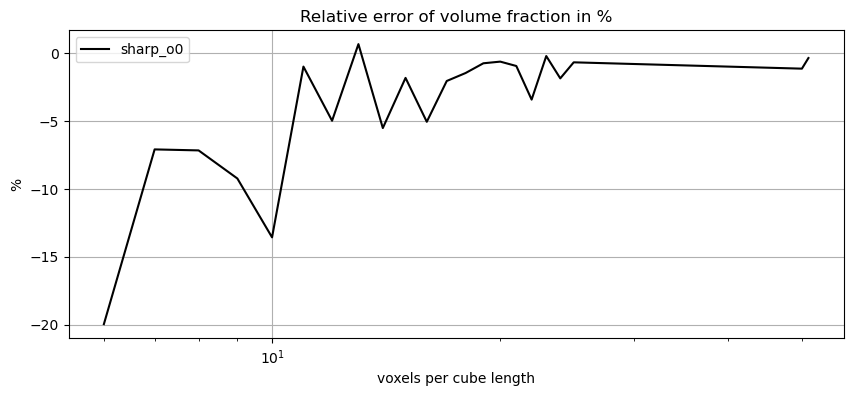

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    ax.semilogx(resolution, (fcc_results[f'overlap{int(100*o)}']['vol']['num']-fcc_results[f'overlap{int(100*o)}']['vol']['theo'])/fcc_results[f'overlap{int(100*o)}']['vol']['theo']*100, label=f'sharp_o{int(100*o)}', color=colors[i], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()
plt.show()

Relative error of surface area computation

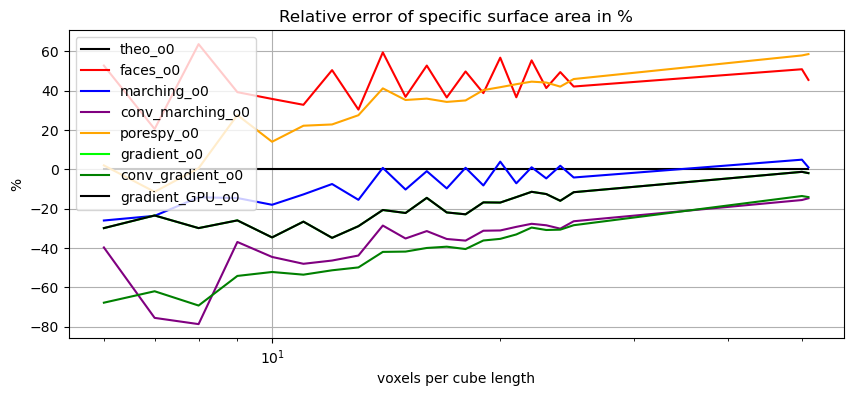

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods):
        rel_error = (fcc_results[f'overlap{int(100*o)}']['area'][method]-fcc_results[f'overlap{int(100*o)}']['area']['theo'])/fcc_results[f'overlap{int(100*o)}']['area']['theo']*100
        ax.semilogx(resolution, rel_error, label=method+f'_o{int(100*o)}', color=colors[j], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of specific surface area in %')
ax.legend()
ax.grid()

plt.show()

And, last but not least, the computation times

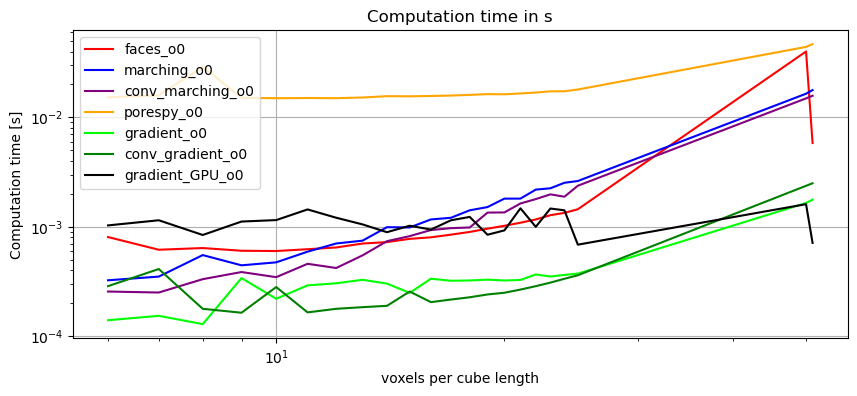

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods[1:]):
        ax.loglog(resolution, fcc_results[f'overlap{int(100*o)}']['time'][method], label=method+f'_o{int(100*o)}', color=colors[j+1], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('Computation time [s]')
ax.set_title('Computation time in s')
ax.legend()
ax.grid()

plt.show()

### Save results to text file
Define a file name and write results dictionary as text table

In [17]:
file_name = "fcc_overlap0.txt"
output = {'pixels':resolution}
buffer = fcc_results['overlap0']
for key,s in buffer['vol'].items():
    header = 'vol_'+key
    output[header] = s
for key,s in buffer['area'].items():
    header = 'a_'+key
    output[header] = s
for key,s in buffer['time'].items():
    header = 't_'+key
    output[header] = s
for key,s in buffer['connected'].items():
    header = 'con_'+key
    output[header] = s
for key,s in buffer['taufactor'].items():
    header = 'tau_'+key
    output[header] = s

data.write_dict_to_txt(output, file_name)
print(f"Data written to {file_name}.")

Data written to fcc_overlap0.txt.
